1.Использовать dataset MovieLens

2.Построить рекомендации (регрессия, предсказываем оценку) на фичах:

 - TF-IDF на тегах и жанрах
 
 - Средние оценки (+ median, variance, etc.) пользователя и фильма

 - Оценить RMSE на тестовой выборке

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [4]:
movies.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [5]:
ratings.head(1)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703


In [6]:
links.head(1)

,movieId,imdbId,tmdbId
0,1,114709,862.0


In [7]:
tags.head(1)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994


### объединяем датафреймы

In [8]:
df_rat_mov = ratings.merge(movies, on='movieId', how='left')

In [9]:
df_rat_mov.head(1)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### преобразуем жанры в числовые признаки

In [10]:
data = df_rat_mov.copy()

In [11]:
data.head(1)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [12]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [13]:
def to_list(s):
    return s.split(' ')

In [14]:
data['genres'] = data['genres'].apply(change_string)

In [15]:
data['genres'] = data['genres'].apply(to_list)

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
one_hot_multiclass = MultiLabelBinarizer()

In [17]:
array_genre = one_hot_multiclass.fit_transform(data['genres'])

In [18]:
array_genre

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]])

In [19]:
one_hot_multiclass.classes_

array(['(nogenreslisted)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'FilmNoir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'SciFi',
       'Thriller', 'War', 'Western'], dtype=object)

In [20]:
df_genre = pd.DataFrame(data=array_genre, columns=['(nogenreslisted)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'FilmNoir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'SciFi',
       'Thriller', 'War', 'Western'])
df_genre.head(1)

,(nogenreslisted),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,FilmNoir,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [21]:
data_with_genre = data.join(df_genre)

In [22]:
data_with_genre.head(2)

,userId,movieId,rating,timestamp,title,genres,(nogenreslisted),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,FilmNoir,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [44]:
# data_with_genre.drop(['genres', '(nogenreslisted)'], axis=1, inplace=True)

### tfidf

In [67]:
tfidf_transformer = TfidfTransformer()

In [77]:
movie_genres = [change_string(g) for g in movies.genres]
movie_genres 

['Adventure Animation Children Comedy Fantasy',
 'Adventure Children Fantasy',
 'Comedy Romance',
 'Comedy Drama Romance',
 'Comedy',
 'Action Crime Thriller',
 'Comedy Romance',
 'Adventure Children',
 'Action',
 'Action Adventure Thriller',
 'Comedy Drama Romance',
 'Comedy Horror',
 'Adventure Animation Children',
 'Drama',
 'Action Adventure Romance',
 'Crime Drama',
 'Drama Romance',
 'Comedy',
 'Comedy',
 'Action Comedy Crime Drama Thriller',
 'Comedy Crime Thriller',
 'Crime Drama Horror Mystery Thriller',
 'Action Crime Thriller',
 'Drama SciFi',
 'Drama Romance',
 'Drama',
 'Children Drama',
 'Drama Romance',
 'Adventure Drama Fantasy Mystery SciFi',
 'Crime Drama',
 'Drama',
 'Mystery SciFi Thriller',
 'Children Drama',
 'Crime Drama',
 'Children Comedy',
 'Comedy Romance',
 'Drama',
 'Drama War',
 'Action Crime Drama',
 'Drama',
 'Action Adventure Fantasy',
 'Comedy Drama Thriller',
 'Drama Romance',
 'Mystery Thriller',
 'Animation Children Drama Musical Romance',
 'Drama R

In [78]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(movie_genres)

In [79]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [80]:
neigh = NearestNeighbors(n_neighbors=5, n_jobs=-1, metric='euclidean') 
neigh.fit(X_train_tfidf)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [81]:
test = change_string("Adventure|Comedy|Fantasy|Crime")

predict = count_vect.transform([test])
X_tfidf2 = tfidf_transformer.transform(predict)

res = neigh.kneighbors(X_tfidf2, return_distance=True)

In [82]:
res

(array([[0.42079615, 0.53300564, 0.54288608, 0.54288608, 0.54288608]]),
 array([[6774, 9096, 5636, 6723, 3376]], dtype=int64))

In [83]:
movies.iloc[res[1][0]]

,movieId,title,genres
6774,60074,Hancock (2008),Action|Adventure|Comedy|Crime|Fantasy
9096,143559,L.A. Slasher (2015),Comedy|Crime|Fantasy
5636,27368,Asterix & Obelix: Mission Cleopatra (Astérix &...,Adventure|Comedy|Fantasy
6723,58972,Nim's Island (2008),Adventure|Comedy|Fantasy
3376,4591,Erik the Viking (1989),Adventure|Comedy|Fantasy


### преобразуем теги в числовые признаки

In [23]:
tags['tag'] = tags['tag'].apply(lambda t: t.lower())

In [24]:
dict_tag = dict(tags.tag.value_counts())
dict_tag 

{'in netflix queue': 131,
 'atmospheric': 41,
 'surreal': 24,
 'superhero': 24,
 'thought-provoking': 24,
 'funny': 24,
 'sci-fi': 23,
 'disney': 23,
 'religion': 22,
 'quirky': 22,
 'psychology': 21,
 'dark comedy': 21,
 'suspense': 21,
 'twist ending': 20,
 'visually appealing': 20,
 'crime': 19,
 'comedy': 19,
 'politics': 19,
 'music': 17,
 'time travel': 16,
 'action': 16,
 'dark': 16,
 'high school': 16,
 'mental illness': 16,
 'aliens': 15,
 'mindfuck': 15,
 'black comedy': 14,
 'dreamlike': 14,
 'space': 14,
 'holocaust': 13,
 'shakespeare': 13,
 'mafia': 13,
 'heist': 13,
 'stephen king': 13,
 'emotional': 13,
 'disturbing': 13,
 'journalism': 13,
 'court': 12,
 'classic': 12,
 'satire': 12,
 'anime': 12,
 'christmas': 12,
 'psychological': 11,
 'adolescence': 11,
 'boxing': 11,
 'ghosts': 11,
 'comic book': 11,
 'bittersweet': 11,
 'imdb top 250': 11,
 'animation': 11,
 'adultery': 11,
 'leonardo dicaprio': 10,
 'vietnam': 10,
 'philosophical': 10,
 'remake': 10,
 'australia'

In [25]:
tags['less_tags'] = tags['tag'].map(dict_tag)

In [26]:
def tags_reduce(low):
    if low['less_tags'] > 9:
        return low['tag']
    else:
        return 'other'

In [27]:
tags['tag_some'] = tags.apply(tags_reduce, axis=1)

In [28]:
tags.head()

,userId,movieId,tag,timestamp,less_tags,tag_some
0,2,60756,funny,1445714994,24,funny
1,2,60756,highly quotable,1445714996,3,other
2,2,60756,will ferrell,1445714992,9,other
3,2,89774,boxing story,1445715207,1,other
4,2,89774,mma,1445715200,1,other


In [29]:
tags.drop(['tag', 'less_tags'], axis=1, inplace=True)

In [30]:
data_all = data_with_genre.merge(tags, on=['movieId', 'userId'], how = 'left')

In [31]:
data_all_ohe = pd.get_dummies(data_all, columns=['tag_some'])

In [32]:
data_all_ohe.head(2)

,userId,movieId,rating,timestamp_x,title,genres,(nogenreslisted),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,FilmNoir,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western,timestamp_y,tag_some_action,tag_some_adolescence,tag_some_adultery,tag_some_aliens,tag_some_animation,tag_some_anime,tag_some_atmospheric,tag_some_australia,tag_some_bittersweet,tag_some_black comedy,tag_some_boxing,tag_some_christmas,tag_some_cinematography,tag_some_classic,tag_some_comedy,tag_some_comic book,tag_some_court,tag_some_crime,tag_some_dark,tag_some_dark comedy,tag_some_disney,tag_some_disturbing,tag_some_dreamlike,tag_some_drugs,tag_some_emotional,tag_some_england,tag_some_funny,tag_some_ghosts,tag_some_heist,tag_some_high school,tag_some_holocaust,tag_some_imdb top 250,tag_some_in netflix queue,tag_some_india,tag_some_journalism,tag_some_leonardo dicaprio,tag_some_mafia,tag_some_mental illness,tag_some_mindfuck,tag_some_music,tag_some_other,tag_some_philosophical,tag_some_politics,tag_some_psychological,tag_some_psychology,tag_some_quirky,tag_some_religion,tag_some_remake,tag_some_robots,tag_some_satire,tag_some_sci-fi,tag_some_shakespeare,tag_some_space,tag_some_stephen king,tag_some_superhero,tag_some_surreal,tag_some_suspense,tag_some_thought-provoking,tag_some_time travel,tag_some_twist ending,tag_some_vietnam,tag_some_visually appealing
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
data_all_ohe.timestamp_y = data_all_ohe.timestamp_y.fillna(0)

In [34]:
data_all_ohe.drop(['genres', '(nogenreslisted)'], axis=1, inplace=True)

### добавляем средние оценки

In [72]:
mean_rating_movie = data_all_ohe.groupby('movieId').mean().reset_index()[['movieId', 'rating']]

In [73]:
mean_rating_user = data_all_ohe.groupby('userId').mean().reset_index()[['userId', 'rating']]

In [74]:
data_with_values = data_all_ohe.merge(mean_rating_movie, on='movieId').merge(mean_rating_user, on='userId')
data_with_values.head(2)

,userId,movieId,rating_x,timestamp_x,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,FilmNoir,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western,timestamp_y,tag_some_action,tag_some_adolescence,tag_some_adultery,tag_some_aliens,tag_some_animation,tag_some_anime,tag_some_atmospheric,tag_some_australia,tag_some_bittersweet,tag_some_black comedy,tag_some_boxing,tag_some_christmas,tag_some_cinematography,tag_some_classic,tag_some_comedy,tag_some_comic book,tag_some_court,tag_some_crime,tag_some_dark,tag_some_dark comedy,tag_some_disney,tag_some_disturbing,tag_some_dreamlike,tag_some_drugs,tag_some_emotional,tag_some_england,tag_some_funny,tag_some_ghosts,tag_some_heist,tag_some_high school,tag_some_holocaust,tag_some_imdb top 250,tag_some_in netflix queue,tag_some_india,tag_some_journalism,tag_some_leonardo dicaprio,tag_some_mafia,tag_some_mental illness,tag_some_mindfuck,tag_some_music,tag_some_other,tag_some_philosophical,tag_some_politics,tag_some_psychological,tag_some_psychology,tag_some_quirky,tag_some_religion,tag_some_remake,tag_some_robots,tag_some_satire,tag_some_sci-fi,tag_some_shakespeare,tag_some_space,tag_some_stephen king,tag_some_superhero,tag_some_surreal,tag_some_suspense,tag_some_thought-provoking,tag_some_time travel,tag_some_twist ending,tag_some_vietnam,tag_some_visually appealing,rating_y,rating
0,1,1,4.0,964982703,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.920930,4.366379
1,1,3,4.0,964981247,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.245283,4.366379


### Modeling

In [76]:
# формируем признаки и целевую переменную
X = data_with_values.drop(['title', 'rating_x', 'userId', 'movieId'], axis=1)
y = data_with_values.rating_x

In [77]:
# разделяем данные на тренировочные и тестовые
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [78]:
# приводим данные к одному масштабу
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# возвращаем к типу датафрейма
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [79]:
clf = RandomForestRegressor()

In [80]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [81]:
# оценим модель
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y_test, clf.predict(X_test))

0.6115136539673646

В среднем регрессор ошибается на 0,61

In [82]:
r2_score(y_test, clf.predict(X_test))

0.44234809196760927

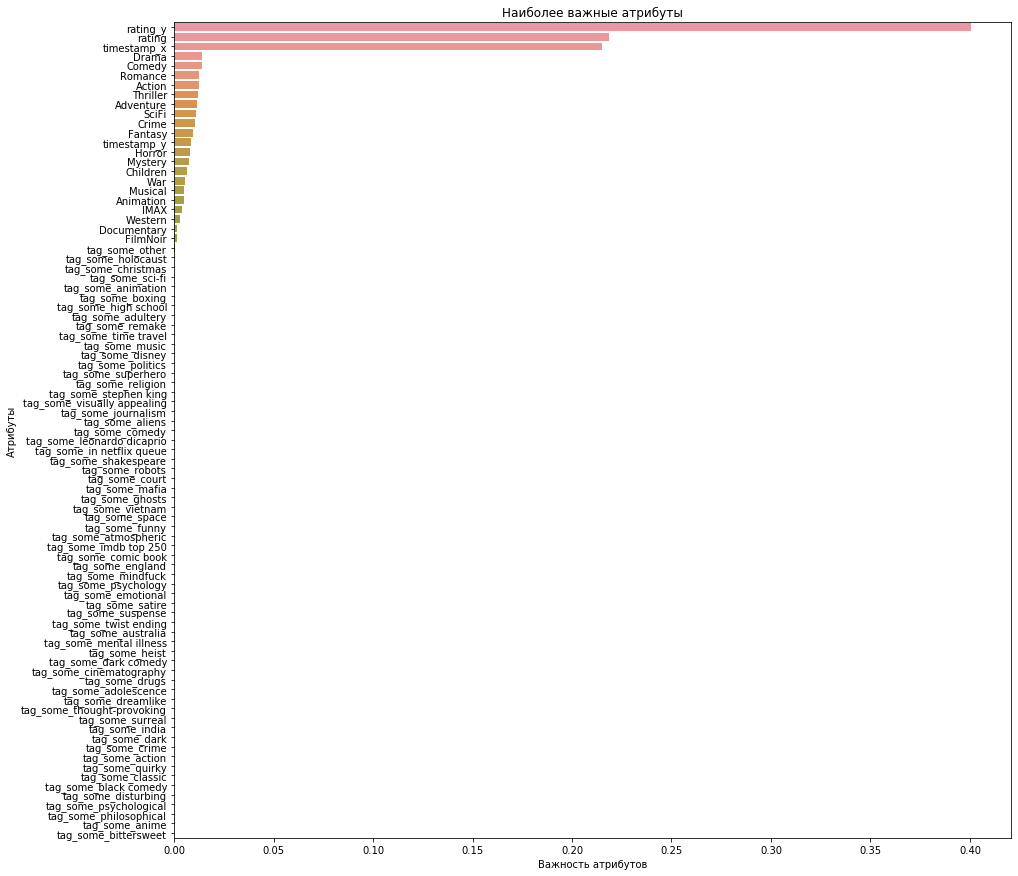

In [86]:
# выводим важность признаков
import seaborn as sns
feature_imp = pd.Series(clf.feature_importances_,index=list(X.columns)).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title('Наиболее важные атрибуты')
plt.show()

In [87]:
feat=feature_imp.index
feat

Index(['rating_y', 'rating', 'timestamp_x', 'Drama', 'Comedy', 'Romance',
       'Action', 'Thriller', 'Adventure', 'SciFi', 'Crime', 'Fantasy',
       'timestamp_y', 'Horror', 'Mystery', 'Children', 'War', 'Musical',
       'Animation', 'IMAX', 'Western', 'Documentary', 'FilmNoir',
       'tag_some_other', 'tag_some_holocaust', 'tag_some_christmas',
       'tag_some_sci-fi', 'tag_some_animation', 'tag_some_boxing',
       'tag_some_high school', 'tag_some_adultery', 'tag_some_remake',
       'tag_some_time travel', 'tag_some_music', 'tag_some_disney',
       'tag_some_politics', 'tag_some_superhero', 'tag_some_religion',
       'tag_some_stephen king', 'tag_some_visually appealing',
       'tag_some_journalism', 'tag_some_aliens', 'tag_some_comedy',
       'tag_some_leonardo dicaprio', 'tag_some_in netflix queue',
       'tag_some_shakespeare', 'tag_some_robots', 'tag_some_court',
       'tag_some_mafia', 'tag_some_ghosts', 'tag_some_vietnam',
       'tag_some_space', 'tag_some_funny'

Попробуем снизить размерность, оставив только наиболее важные признаки для регрессора

In [88]:
# формируем признаки и целевую переменную
XX = data_with_values[['rating_y', 'rating', 'timestamp_x', 'Drama', 'Comedy', 'Romance',
       'Action', 'Thriller', 'Adventure', 'SciFi', 'Crime', 'Fantasy',
       'timestamp_y', 'Horror', 'Mystery', 'Children', 'War', 'Musical',
       'Animation', 'IMAX', 'Western', 'Documentary', 'FilmNoir']]
yy = data_with_values.rating_x

In [89]:
# разделяем данные на тренировочные и тестовые
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.25)

In [91]:
# приводим данные к одному масштабу
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# возвращаем к типу датафрейма
X_train = pd.DataFrame(X_train, columns=XX.columns)
X_test = pd.DataFrame(X_test, columns=XX.columns)

In [92]:
clf_less_features = RandomForestRegressor()

In [93]:
clf_less_features.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [94]:
# оценим модель
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y_test, clf_less_features.predict(X_test))

0.620108643416108

In [95]:
r2_score(y_test, clf_less_features.predict(X_test))

0.42641585143350724

Признаковое пространство уменьшили значительно, качество осталось примерно таким же